### Importing Libraries

In [3]:
import torch
import torchvision
from torchvision.datasets.utils import download_and_extract_archive

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
from os import path
from PIL import Image
import numpy as np

from tqdm import tqdm

from IPython import display
import matplotlib.pyplot as plt

import datetime
from datetime import datetime

import cv2

### Downloading Maps Data
For training the model, we would be using the same dataset as used by the pix2pix authors, which is publicly availabe.

*   Dataset Url : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
*   Dataset Size : 240 MB

In [ ]:
dataset_name = "maps"
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

# Downloading and extracting the dataset
download_and_extract_archive(
    _URL, download_root='./', extract_root='./', remove_finished=True)

### Setting up the environment and Hyperparameters

In [4]:
PATH_NAME = f'./'
DATA_PATH = f'./maps'
LOAD_PATH = f'./hpix-weights/'

In [5]:
eval_folder = './training_images'
if not os.path.exists(eval_folder):
    os.makedirs(eval_folder)

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
BATCH_SIZE = 1
START_EPOCH = 151
NUM_EPOCHS = 200
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
LAMBDA_L1 = 100
LOAD_MODEL = True
SAVE_MODEL = True
LOAD_GEN_GLOBAL = f'{LOAD_PATH}global_gen.pth.tar'
LOAD_DISC_GLOBAL = f'{LOAD_PATH}global_disc.pth.tar'
LOAD_GEN_LOCAL = f'{LOAD_PATH}local_gen.pth.tar'
LOAD_DISC_LOCAL = f'{LOAD_PATH}local_disc.pth.tar'
CHECKPOINT_GEN_GLOBAL = f'{PATH_NAME}global_gen.pth.tar'
CHECKPOINT_DISC_GLOBAL = f'{PATH_NAME}global_disc.pth.tar'
CHECKPOINT_GEN_LOCAL = f'{PATH_NAME}local_gen.pth.tar'
CHECKPOINT_DISC_LOCAL = f'{PATH_NAME}local_disc.pth.tar'

both_transform_train = A.Compose(
    [A.Resize(286, 286),
     A.RandomCrop(256, 256),
     A.HorizontalFlip(p=0.5),],
    additional_targets={"image0": "image"},
)

both_transform_test = A.Compose(
    [A.Resize(256, 256)],
    additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[
                    0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ],
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[
                    0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ],
)

### Defining the helper functions

In [7]:
def save_checkpoint(model, optimizer, filename='my_checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print('=> Loading Checkpoint')
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def save_example(global_gen, local_gen, val_loader, epoch, folder, deep_supervision=False):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    global_gen.eval()
    local_gen.eval()
    with torch.no_grad():
        if deep_supervision:
            y_fake_g = global_gen(x)[6]
        else:
            y_fake_g = global_gen(x)

        y_fake = local_gen(x, y_fake_g)

        # Remove Normalization
        y_fake = y_fake * 0.5 + 0.5
        y_fake_g = y_fake_g * 0.5 + 0.5
        x = x * 0.5 + 0.5
        y = y * 0.5 + 0.5

        # Create a figure with 4 subplots
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(x[0].permute(1, 2, 0).cpu().numpy())
        axs[0].axis('off')
        axs[0].set_title('Satellite Image')

        axs[1].imshow(y[0].permute(1, 2, 0).cpu().numpy())
        axs[1].axis('off')
        axs[1].set_title('Target Image')

        axs[2].imshow(y_fake_g[0].permute(1, 2, 0).cpu().numpy())
        axs[2].axis('off')
        axs[2].set_title('Global Generated')

        axs[3].imshow(y_fake[0].permute(1, 2, 0).cpu().numpy())
        axs[3].axis('off')
        axs[3].set_title('Local Generated')

        # Save the figure
        plt.savefig(f'{PATH_NAME}{folder}/combined_{epoch}.png')

        # Show the output
        plt.show()
    global_gen.train()
    local_gen.train()

### Defining the Train and Test Data loaders

In [8]:
# Defining the dataset loader function
class MapDatasetLoader(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_file = self.files[idx]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_img = image[:, :600, :]
        target_img = image[:, 600:, :]

        augmented = both_transform_train(image=input_img, image0=target_img)
        input_img, target_img = augmented["image"], augmented["image0"]
        input_img = transform_only_input(image=input_img)["image"]
        target_img = transform_only_mask(image=target_img)["image"]

        return input_img, target_img

In [9]:
# Defining the dataset loader function for validation
class ValDatasetLoader(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_file = self.files[idx]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_img = image[:, :600, :]
        target_img = image[:, 600:, :]

        augmented = both_transform_test(image=input_img, image0=target_img)
        input_img, target_img = augmented["image"], augmented["image0"]
        input_img = transform_only_input(image=input_img)["image"]
        target_img = transform_only_mask(image=target_img)["image"]

        return input_img, target_img

### Defining the training dataset

In [11]:
# Loading training dataset
data_path = f'{DATA_PATH}/train'
dataset = MapDatasetLoader(data_path)
print('Number of training examples:', len(dataset))

Number of training examples: 1096


Now, we will visualize a sample image from the training dataset.

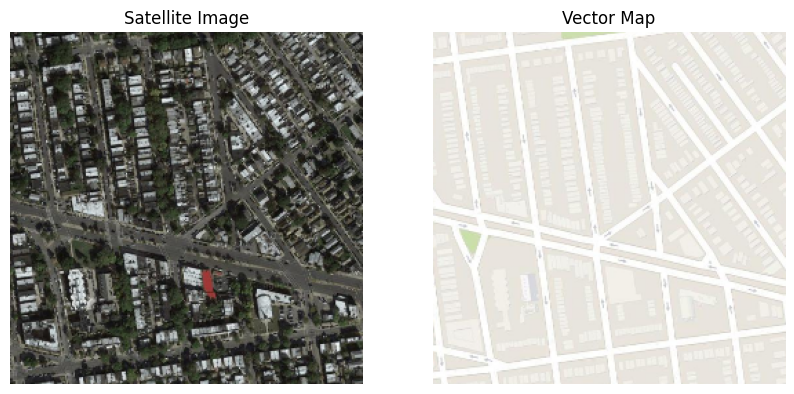

In [12]:
(satellite, map) = dataset[0]

# Un-normalize the data
satellite = satellite * 0.5 + 0.5
map = map * 0.5 + 0.5

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Satellite Image')
plt.imshow(satellite.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(map.permute(1, 2, 0))
plt.axis('off')
plt.title('Vector Map')
plt.show()

### Defining the Generator and Discriminator
We will first define the global generator, then the Local generator and then the Discriminator for global and local level.

#### Global Generator:

In [13]:
class GlobalBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 4, 2, 1,
                            bias=False, padding_mode='reflect')
            if downsample
            else torch.nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            torch.nn.InstanceNorm2d(out_channels, affine=True),
            torch.nn.ReLU() if act == 'relu' else torch.nn.LeakyReLU(0.2)
        )
        self.use_dropout = use_dropout
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [14]:
class TransitionBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.leakyrelu = torch.nn.LeakyReLU(0.2)
        self.conv = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.inorm = torch.nn.InstanceNorm2d(out_channels, affine=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.inorm(out)
        out = self.leakyrelu(out)
        return out

In [15]:
class GlobalGenerator(torch.nn.Module):
    def __init__(self, in_channels=3, deep_supervision=False, **kwargs):
        super().__init__()
        features = [64, 128, 256, 512, 512, 512, 512]

        self.up1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(features[1], features[0], 4, 2, 1),
            torch.nn.InstanceNorm2d(features[0], affine=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5)
        )
        self.up2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(features[2], features[1], 4, 2, 1),
            torch.nn.InstanceNorm2d(features[1], affine=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5)
        )
        self.up3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(features[3], features[2], 4, 2, 1),
            torch.nn.InstanceNorm2d(features[2], affine=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5)
        )
        self.up4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(features[4], features[3], 4, 2, 1),
            torch.nn.InstanceNorm2d(features[3], affine=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5)
        )
        self.up5 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(features[5], features[4], 4, 2, 1),
            torch.nn.InstanceNorm2d(features[4], affine=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5)
        )
        self.up6 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(features[6], features[5], 4, 2, 1),
            torch.nn.InstanceNorm2d(features[5], affine=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5)
        )

        self.deep_supervision = deep_supervision

        self.conv0_0 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels, features[0], 4, 2, 1, padding_mode='reflect'),
            torch.nn.LeakyReLU(0.2)
        )
        self.conv1_0 = GlobalBlock(
            features[0], features[1], downsample=True, use_dropout=False, act='leaky')
        self.conv2_0 = GlobalBlock(
            features[1], features[2], downsample=True, use_dropout=False, act='leaky')
        self.conv3_0 = GlobalBlock(
            features[2], features[3], downsample=True, use_dropout=False, act='leaky')
        self.conv4_0 = GlobalBlock(
            features[3], features[4], downsample=True, use_dropout=False, act='leaky')
        self.conv5_0 = GlobalBlock(
            features[4], features[5], downsample=True, use_dropout=False, act='leaky')
        self.conv6_0 = GlobalBlock(
            features[5], features[6], downsample=True, use_dropout=False, act='leaky')

        self.conv7_0 = torch.nn.Sequential(
            torch.nn.Conv2d(features[6], features[6],
                            4, 2, 1, padding_mode='reflect'),
        )
        self.conv7_1 = GlobalBlock(
            features[6], features[6], downsample=False, use_dropout=True, act='relu')

        self.conv0_1 = TransitionBlock(features[0] * 2, features[0])
        self.conv1_1 = TransitionBlock(features[1] * 2, features[1])
        self.conv2_1 = TransitionBlock(features[2] * 2, features[2])
        self.conv3_1 = TransitionBlock(features[3] * 2, features[3])
        self.conv4_1 = TransitionBlock(features[4] * 2, features[4])
        self.conv5_1 = TransitionBlock(features[5] * 2, features[5])
        self.conv6_1 = GlobalBlock(
            features[6] * 2, features[5], downsample=False, use_dropout=True, act='relu')

        self.conv0_2 = TransitionBlock(features[0] * 3, features[0])
        self.conv1_2 = TransitionBlock(features[1] * 3, features[1])
        self.conv2_2 = TransitionBlock(features[2] * 3, features[2])
        self.conv3_2 = TransitionBlock(features[3] * 3, features[3])
        self.conv4_2 = TransitionBlock(features[4] * 3, features[4])
        self.conv5_2 = GlobalBlock(features[5] * 3, features[4],
                                   downsample=False, use_dropout=True, act='relu')

        self.conv0_3 = TransitionBlock(features[0] * 4, features[0])
        self.conv1_3 = TransitionBlock(features[1] * 4, features[1])
        self.conv2_3 = TransitionBlock(features[2] * 4, features[2])
        self.conv3_3 = TransitionBlock(features[3] * 4, features[3])
        self.conv4_3 = GlobalBlock(features[4] * 4, features[3],
                                   downsample=False, use_dropout=True, act='relu')

        self.conv0_4 = TransitionBlock(features[0] * 5, features[0])
        self.conv1_4 = TransitionBlock(features[1] * 5, features[1])
        self.conv2_4 = TransitionBlock(features[2] * 5, features[2])
        self.conv3_4 = GlobalBlock(features[3] * 5, features[2],
                                   downsample=False, use_dropout=True, act='relu')

        self.conv0_5 = TransitionBlock(features[0] * 6, features[0])
        self.conv1_5 = TransitionBlock(features[1] * 6, features[1])
        self.conv2_5 = GlobalBlock(features[2] * 6, features[1],
                                   downsample=False, use_dropout=True, act='relu')

        self.conv0_6 = TransitionBlock(features[0] * 7, features[0])
        self.conv1_6 = GlobalBlock(features[1] * 7, features[0],
                                   downsample=False, use_dropout=True, act='relu')

        if self.deep_supervision:
            self.final1 = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(features[0], in_channels, 4, 2, 1),
                torch.nn.Tanh()
            )
            self.final2 = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(features[0], in_channels, 4, 2, 1),
                torch.nn.Tanh()
            )
            self.final3 = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(features[0], in_channels, 4, 2, 1),
                torch.nn.Tanh()
            )
            self.final4 = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(features[0], in_channels, 4, 2, 1),
                torch.nn.Tanh()
            )
            self.final5 = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(features[0], in_channels, 4, 2, 1),
                torch.nn.Tanh()
            )
            self.final6 = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(features[0], in_channels, 4, 2, 1),
                torch.nn.Tanh()
            )
            self.final7 = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    features[0] * 8, in_channels, 4, 2, 1),
                torch.nn.Tanh()
            )
        else:
            self.final = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    features[0] * 8, in_channels, 4, 2, 1),
                torch.nn.Tanh()
            )

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(x0_0)
        x2_0 = self.conv2_0(x1_0)
        x3_0 = self.conv3_0(x2_0)
        x4_0 = self.conv4_0(x3_0)
        x5_0 = self.conv5_0(x4_0)
        x6_0 = self.conv6_0(x5_0)
        x7_0 = self.conv7_0(x6_0)
        x7_1 = self.conv7_1(x7_0)

        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1(x1_0)], dim=1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2(x2_0)], dim=1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3(x3_0)], dim=1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up4(x4_0)], dim=1))
        x4_1 = self.conv4_1(torch.cat([x4_0, self.up5(x5_0)], dim=1))
        x5_1 = self.conv5_1(torch.cat([x5_0, self.up6(x6_0)], dim=1))
        x6_1 = self.conv6_1(torch.cat([x6_0, x7_1], dim=1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1(x1_1)], dim=1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2(x2_1)], dim=1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3(x3_1)], dim=1))
        x3_2 = self.conv3_2(torch.cat([x3_0, x3_1, self.up4(x4_1)], dim=1))
        x4_2 = self.conv4_2(torch.cat([x4_0, x4_1, self.up5(x5_1)], dim=1))
        x5_2 = self.conv5_2(torch.cat([x5_0, x5_1, x6_1], dim=1))

        x0_3 = self.conv0_3(
            torch.cat([x0_0, x0_1, x0_2, self.up1(x1_2)], dim=1))
        x1_3 = self.conv1_3(
            torch.cat([x1_0, x1_1, x1_2, self.up2(x2_2)], dim=1))
        x2_3 = self.conv2_3(
            torch.cat([x2_0, x2_1, x2_2, self.up3(x3_2)], dim=1))
        x3_3 = self.conv3_3(
            torch.cat([x3_0, x3_1, x3_2, self.up4(x4_2)], dim=1))
        x4_3 = self.conv4_3(torch.cat([x4_0, x4_1, x4_2, x5_2], dim=1))

        x0_4 = self.conv0_4(
            torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1(x1_3)], dim=1))
        x1_4 = self.conv1_4(
            torch.cat([x1_0, x1_1, x1_2, x1_3, self.up2(x2_3)], dim=1))
        x2_4 = self.conv2_4(
            torch.cat([x2_0, x2_1, x2_2, x2_3, self.up3(x3_3)], dim=1))
        x3_4 = self.conv3_4(torch.cat([x3_0, x3_1, x3_2, x3_3, x4_3], dim=1))

        x0_5 = self.conv0_5(
            torch.cat([x0_0, x0_1, x0_2, x0_3, x0_4, self.up1(x1_4)], dim=1))
        x1_5 = self.conv1_5(
            torch.cat([x1_0, x1_1, x1_2, x1_3, x1_4, self.up2(x2_4)], dim=1))
        x2_5 = self.conv2_5(
            torch.cat([x2_0, x2_1, x2_2, x2_3, x2_4, x3_4], dim=1))

        x0_6 = self.conv0_6(
            torch.cat([x0_0, x0_1, x0_2, x0_3, x0_4, x0_5, self.up1(x1_5)], dim=1))
        x1_6 = self.conv1_6(
            torch.cat([x1_0, x1_1, x1_2, x1_3, x1_4, x1_5, x2_5], dim=1))

        if self.deep_supervision:
            o1 = self.final1(x0_1)
            o2 = self.final2(x0_2)
            o3 = self.final3(x0_3)
            o4 = self.final4(x0_4)
            o5 = self.final5(x0_5)
            o6 = self.final6(x0_6)
            o7 = self.final7(
                torch.cat([x0_0, x0_1, x0_2, x0_3, x0_4, x0_5, x0_6, x1_6], dim=1))

            return [o1, o2, o3, o4, o5, o6, o7]
        else:
            final = self.final(
                torch.cat([x0_0, x0_1, x0_2, x0_3, x0_4, x0_5, x0_6, x1_6], dim=1))

            return final

Now, we will test the global generator with a random input image. The output of the global generator should match the input image.

In [16]:
def test_global_gen():
    x = torch.randn((1, 3, 256, 256))
    model = GlobalGenerator(in_channels=3, deep_supervision=True)
    preds = model(x)
    print('Global Generator Output Shape:', preds[-1].shape)

test_global_gen()

Global Generator Output Shape: torch.Size([1, 3, 256, 256])


#### Local Generator:

In [17]:
class LocalBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 4, 2, 1,
                            bias=False, padding_mode='reflect')
            if down
            else torch.nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            torch.nn.InstanceNorm2d(out_channels, affine=True),
            torch.nn.ReLU() if act == 'relu' else torch.nn.LeakyReLU(0.2)
        )
        self.use_dropout = use_dropout
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [18]:
class LocalGenerator(torch.nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels*2, features, 4, 2,
                            1, padding_mode='reflect'),
            torch.nn.LeakyReLU(0.2)
        )  # 128
        self.down1 = LocalBlock(features, features * 2, down=True,
                                use_dropout=False, act='leaky')  # 64
        self.down2 = LocalBlock(features * 2, features * 4,
                                down=True, use_dropout=False, act='leaky')  # 32
        self.down3 = LocalBlock(features * 4, features * 8,
                                down=True, use_dropout=False, act='leaky')  # 16
        self.down4 = LocalBlock(features * 8, features * 8,
                                down=True, use_dropout=False, act='leaky')  # 8
        self.down5 = LocalBlock(features * 8, features * 8,
                                down=True, use_dropout=False, act='leaky')  # 4
        self.down6 = LocalBlock(features * 8, features * 8,
                                down=True, use_dropout=False, act='leaky')  # 2

        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(features * 8, features * 8, 4, 2,
                            1, padding_mode='reflect'),  # 1
        )

        self.up1 = LocalBlock(features * 8, features * 8, down=False,
                              use_dropout=True, act='relu')  # 4
        self.up2 = LocalBlock(features * 8 * 2, features * 8,
                              down=False, use_dropout=True, act='relu')  # 8
        self.up3 = LocalBlock(features * 8 * 2, features * 8,
                              down=False, use_dropout=True, act='relu')  # 16
        self.up4 = LocalBlock(features * 8 * 2, features * 8,
                              down=False, use_dropout=False, act='relu')  # 32
        self.up5 = LocalBlock(features * 8 * 2, features * 4,
                              down=False, use_dropout=False, act='relu')  # 64
        self.up6 = LocalBlock(features * 4 * 2, features * 2,
                              down=False, use_dropout=False, act='relu')  # 128
        self.up7 = LocalBlock(features * 2 * 2, features, down=False,
                              use_dropout=False, act='relu')  # 256

        self.final_up = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(features * 2, in_channels, 4, 2, 1),
            torch.nn.Tanh()
        )

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

Now, we will test the local generator with a random input image. The local generator takes two images and gives single output. The output of the local generator should match the size of one input image.

In [19]:
def test_local_gen():
    x1 = torch.randn((1, 3, 256, 256))
    x2 = torch.randn((1, 3, 256, 256))
    model = LocalGenerator(in_channels=3)
    preds = model(x1, x2)
    print('Local Generator Output Shape:', preds.shape)

test_local_gen()

Local Generator Output Shape: torch.Size([1, 3, 256, 256])


#### Discriminator:
Now, we will define the discriminator for global and local level. The discriminator takes two images and gives single output.

In [20]:
class CNNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 4, stride,
                            bias=False, padding_mode='reflect'),
            torch.nn.InstanceNorm2d(out_channels, affine=True),
            torch.nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.conv(x)

In [21]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(Discriminator, self).__init__()
        self.initial = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            torch.nn.LeakyReLU(0.2)
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature,
                         stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            torch.nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'
            )
        )
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

Now, we will test the discriminator with a random input image. The output of the discriminator should be a 26 * 26 patch.

In [22]:
def test_dis():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator()
    preds = model(x, y)
    print('Discriminator Output Shape:', preds.shape)

test_dis()

Discriminator Output Shape: torch.Size([1, 1, 26, 26])


### Training the model

In [ ]:
def train(global_disc, global_gen, local_disc, local_gen, loader, opt_disc_global, opt_gen_global, opt_disc_local, opt_gen_local, global_g_scaler, global_d_scaler, local_g_scaler, local_d_scaler, g_l1, g_bce, l_l1, l_bce):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Train Global Discriminator
        with torch.cuda.amp.autocast():
            global_y_fake_list = global_gen(x)
            global_d_real = global_disc(x, y)
            global_d_fake_0 = global_disc(x, global_y_fake_list[0].detach())
            global_d_fake_1 = global_disc(x, global_y_fake_list[1].detach())
            global_d_fake_2 = global_disc(x, global_y_fake_list[2].detach())
            global_d_fake_3 = global_disc(x, global_y_fake_list[3].detach())
            global_d_fake_4 = global_disc(x, global_y_fake_list[4].detach())
            global_d_fake_5 = global_disc(x, global_y_fake_list[5].detach())
            global_d_fake_6 = global_disc(x, global_y_fake_list[6].detach())

            global_d_fake = (global_d_fake_0 + global_d_fake_1 + global_d_fake_2 + global_d_fake_3 +
                             global_d_fake_4 + global_d_fake_5 + global_d_fake_6) / 7
            global_d_real_loss = g_bce(
                global_d_real, torch.ones_like(global_d_real))
            global_d_fake_loss = g_bce(
                global_d_fake, torch.zeros_like(global_d_fake))
            global_d_loss = (global_d_real_loss + global_d_fake_loss) / 2

        opt_disc_global.zero_grad()
        global_d_scaler.scale(global_d_loss).backward()
        global_d_scaler.step(opt_disc_global)
        global_d_scaler.update()

        # Train Global Generator
        with torch.cuda.amp.autocast():
            global_d_fake_0 = global_disc(x, global_y_fake_list[0].detach())
            global_d_fake_1 = global_disc(x, global_y_fake_list[1].detach())
            global_d_fake_2 = global_disc(x, global_y_fake_list[2].detach())
            global_d_fake_3 = global_disc(x, global_y_fake_list[3].detach())
            global_d_fake_4 = global_disc(x, global_y_fake_list[4].detach())
            global_d_fake_5 = global_disc(x, global_y_fake_list[5].detach())
            global_d_fake_6 = global_disc(x, global_y_fake_list[6].detach())
            global_d_fake = (global_d_fake_0 + global_d_fake_1 + global_d_fake_2 + global_d_fake_3 +
                             global_d_fake_4 + global_d_fake_5 + global_d_fake_6) / 7

            global_g_fake_loss = g_bce(
                global_d_fake, torch.ones_like(global_d_fake))
            global_l_total = g_l1(global_y_fake_list[0], y) + g_l1(global_y_fake_list[1], y) + g_l1(global_y_fake_list[2], y) + g_l1(
                global_y_fake_list[3], y) + g_l1(global_y_fake_list[4], y) + g_l1(global_y_fake_list[5], y) + g_l1(global_y_fake_list[6], y)
            global_L1 = global_l_total * LAMBDA_L1
            global_g_loss = global_g_fake_loss + global_L1

        opt_gen_global.zero_grad()
        global_g_scaler.scale(global_g_loss).backward()
        global_g_scaler.step(opt_gen_global)
        global_g_scaler.update()

        # Train Local Discriminator
        with torch.cuda.amp.autocast():
            local_y_fake = local_gen(x, global_y_fake_list[6].detach())
            local_d_real = local_disc(x, y)
            local_d_fake = local_disc(x, local_y_fake.detach())
            local_d_real_loss = l_bce(
                local_d_real, torch.ones_like(local_d_real))
            local_d_fake_loss = l_bce(
                local_d_fake, torch.zeros_like(local_d_fake))
            local_d_loss = (local_d_real_loss + local_d_fake_loss) / 2

        opt_disc_local.zero_grad()
        local_d_scaler.scale(local_d_loss).backward()
        local_d_scaler.step(opt_disc_local)
        local_d_scaler.update()

        # Train Local Generator
        with torch.cuda.amp.autocast():
            local_d_fake = local_disc(x, local_y_fake.detach())
            local_g_fake_loss = l_bce(
                local_d_fake, torch.ones_like(local_d_fake))
            local_l1 = l_l1(local_y_fake, y) * LAMBDA_L1
            local_g_loss = local_g_fake_loss + local_l1

        opt_gen_local.zero_grad()
        local_g_scaler.scale(local_g_loss).backward()
        local_g_scaler.step(opt_gen_local)
        local_g_scaler.update()

In [ ]:
def main():
    global_disc = Discriminator(in_channels=3).to(DEVICE)
    global_gen = GlobalGenerator(
        in_channels=3, deep_supervision=True).to(DEVICE)
    local_disc = Discriminator(in_channels=3).to(DEVICE)
    local_gen = LocalGenerator(in_channels=3).to(DEVICE)

    opt_disc_global = torch.optim.Adam(
        global_disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen_global = torch.optim.Adam(
        global_gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_disc_local = torch.optim.Adam(
        local_disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen_local = torch.optim.Adam(
        local_gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

    g_BCE = torch.nn.BCEWithLogitsLoss()
    l_BCE = torch.nn.BCEWithLogitsLoss()
    g_L1 = torch.nn.L1Loss()
    l_L1 = torch.nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(LOAD_GEN_GLOBAL, global_gen,
                        opt_gen_global, LEARNING_RATE)
        load_checkpoint(LOAD_DISC_GLOBAL, global_disc,
                        opt_disc_global, LEARNING_RATE)
        load_checkpoint(LOAD_GEN_LOCAL, local_gen,
                        opt_gen_local, LEARNING_RATE)
        load_checkpoint(LOAD_DISC_LOCAL, local_disc,
                        opt_disc_local, LEARNING_RATE)

    train_dataset_path = f'{DATA_PATH}/train'
    train_dataset = MapDatasetLoader(root_dir=train_dataset_path)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    global_g_scaler = torch.cuda.amp.GradScaler()
    global_d_scaler = torch.cuda.amp.GradScaler()
    local_g_scaler = torch.cuda.amp.GradScaler()
    local_d_scaler = torch.cuda.amp.GradScaler()

    val_dataset_path = f'{DATA_PATH}/val'
    val_dataset = ValDatasetLoader(root_dir=val_dataset_path)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False)

    for epoch in range(START_EPOCH, NUM_EPOCHS+1):
        print('Epoch:', epoch)
        train(
            global_disc, global_gen,
            local_disc, local_gen,
            train_loader,
            opt_disc_global, opt_gen_global,
            opt_disc_local, opt_gen_local,
            global_g_scaler, global_d_scaler,
            local_g_scaler, local_d_scaler,
            g_L1, g_BCE, l_L1, l_BCE
        )

        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(global_gen, opt_gen_global,
                            filename=CHECKPOINT_GEN_GLOBAL)
            save_checkpoint(global_disc, opt_disc_global,
                            filename=CHECKPOINT_DISC_GLOBAL)
            save_checkpoint(local_gen, opt_gen_local,
                            filename=CHECKPOINT_GEN_LOCAL)
            save_checkpoint(local_disc, opt_disc_local,
                            filename=CHECKPOINT_DISC_LOCAL)

        save_example(global_gen, local_gen, val_loader,
                     epoch, folder='training_images',
                     deep_supervision=True)

In [ ]:
if __name__ == '__main__':
    main()